# 11.0 Model Evaluation and Training
Here I perform the following tasks:

- 1) Evaluate the performance of different algorithms with KFold cross-validation, to determine which is best at modeling un-seen data.
- 2) After selecting an algorithm I perform a feature importance analysis to remove features that are not adding any value.
- 3) Peform a grid search to find the optimal parameters for the final algorithm.
- 4) Train the final model.
- 5) Prepare a home credit competition submission file.

In [18]:
#ml algorithms
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold 
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#nerual networks api
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from keras import optimizers
import tensorflow as tf

import seaborn as sns
sns.set(style="whitegrid")
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

## 11.1 Import Normalized Dataset
Here we import the training that has already been normalized.

In [19]:
dataset =  pd.read_csv(r"C:\Users\Duong Nguyen\Desktop\final_project\home-credit-default-risk\results\train_norm.csv")

In [20]:
dataset.head()

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,EXT_SOURCE_2,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,EXT_SOURCE_1,EXT_SOURCE_3,...,NAME_FAMILY_STATUS_MAP_2,NAME_FAMILY_STATUS_MAP_3,NAME_FAMILY_STATUS_MAP_4,NAME_FAMILY_STATUS_MAP_5,NAME_HOUSING_TYPE_MAP_0,NAME_HOUSING_TYPE_MAP_1,NAME_HOUSING_TYPE_MAP_2,NAME_HOUSING_TYPE_MAP_3,NAME_HOUSING_TYPE_MAP_4,NAME_HOUSING_TYPE_MAP_5
0,-0.862538,-0.743626,-1.014157,-0.019215,0.356886,-1.175831,2.438415,0.570637,-1.971493,-1.176664,...,0,1,0,0,0,0,0,0,0,1
1,0.160922,-0.519331,0.697882,-0.650005,-0.359306,1.065978,-0.310240,-1.573089,-0.455155,0.031456,...,0,0,0,0,0,1,0,0,0,0
2,1.157228,2.179913,1.599043,2.029631,-0.432682,1.136863,-0.310240,0.775340,3.522805,0.185182,...,0,0,0,0,0,1,0,0,0,0
3,1.075578,0.531229,2.062030,-0.019215,0.655172,0.945854,-0.310240,0.418680,-1.239534,2.084732,...,0,0,0,0,0,1,0,0,0,0
4,-1.706757,0.748108,1.355544,-0.729995,-1.508412,-0.438918,-0.310240,0.088393,1.920078,1.086620,...,0,0,0,0,0,1,0,0,0,0


## 11.2 Define Evaluate Models Performance

In [21]:
# define roc_callback
def auc_roc(y_true, y_pred):
    value, update_op = tf.metrics.auc(y_pred, y_true)

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value

In [22]:
dataset.columns = list(map(lambda x: str(x).replace(" ", "_").replace("-", "_").replace("_/_", "_").upper(), dataset.columns))
import re
dataset = dataset.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [24]:
train = dataset[dataset.TARGET.isnull() == False]
test = dataset[dataset.TARGET.isnull()]

X_train = train.drop(["TARGET", "SK_ID_CURR"], axis = 1)
X_test = test.drop(["TARGET", "SK_ID_CURR"], axis = 1)
y_train = train.TARGET

# split into train/test sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=54,stratify=y_train)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.1, random_state=54,stratify=y_val)
print("X training size: {} and y training size {}:".format(X_train.shape,y_train.shape))
print("X validation size: {} and y validation size {}:".format(X_val.shape,y_val.shape))
print("X testing size: {} and y testing size {}:".format(X_test.shape,y_test.shape))

X training size: (43616, 320) and y training size (43616,):
X validation size: (4362, 320) and y validation size (4362,):
X testing size: (485, 320) and y testing size (485,):


## 11.3 LGBM Tunning

In [28]:
#define a function to perform a grid search on the LGBM model
def randSearchLGBM(rand_Params):
    """Perform grid search on LGBM"""
    
    mdl = LGBMClassifier(random_state=54)
    # Create the grid
    kfold = StratifiedKFold(n_splits=5)
    scoring = {'AUC': 'roc_auc'}
    rand = RandomizedSearchCV(mdl, rand_Params,verbose=0,cv=kfold,scoring = scoring , n_jobs=-1, refit='AUC')

    # Run the grid
    rand.fit(X_train, y_train ,verbose=0, 
                eval_set=[(X_val, y_val)], 
                eval_metric= 'auc')

    # Print the best parameters found
    print(rand.best_params_)
    print(rand.best_score_)

In [29]:
# Create parameters to search for num_leaves and max_depth
randParams = {
    'num_leaves': [15,25,35,45],
    'max_depth': [15,20,25,30]
    }

randSearchLGBM(randParams)

{'num_leaves': 25, 'max_depth': 30}
0.7686191635705862


In [9]:
# Create parameters to search for learning rate and estimators
randParams = {
    'learning_rate': [0.04,0.07,0.1],
    'n_estimators': [100,300,600,800],
    'num_leaves': [25],
    'max_depth': [20]
    }

randSearchLGBM(randParams)

{'num_leaves': 25, 'n_estimators': 300, 'max_depth': 20, 'learning_rate': 0.04}
0.7702170642547367


## 11.4 Train Final Model

In [39]:
final_model = LGBMClassifier(
    nthread=4,
    n_estimators=10000,
    learning_rate=0.02,
    num_leaves=34,
    colsample_bytree=0.9497036,
    subsample=0.8715623,
    max_depth=8,
    reg_alpha=0.041545473,
    reg_lambda=0.0735294,
    min_split_gain=0.0222415,
    min_child_weight=39.3259775,
    silent=-1,
    verbose=-1, )

history = final_model.fit(X_train, y_train , 
                eval_set=[(X_train, y_train),(X_val, y_val)], 
                eval_metric='auc', verbose=200, early_stopping_rounds= 200)

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.801519	training's binary_logloss: 0.555266	valid_1's auc: 0.772909	valid_1's binary_logloss: 0.57648
[400]	training's auc: 0.828957	training's binary_logloss: 0.521756	valid_1's auc: 0.779378	valid_1's binary_logloss: 0.566092
[600]	training's auc: 0.848308	training's binary_logloss: 0.499691	valid_1's auc: 0.781495	valid_1's binary_logloss: 0.56316
[800]	training's auc: 0.864497	training's binary_logloss: 0.481237	valid_1's auc: 0.782613	valid_1's binary_logloss: 0.561833
[1000]	training's auc: 0.878221	training's binary_logloss: 0.46539	valid_1's auc: 0.782739	valid_1's binary_logloss: 0.561729
Early stopping, best iteration is:
[868]	training's auc: 0.869234	training's binary_logloss: 0.475745	valid_1's auc: 0.782841	valid_1's binary_logloss: 0.561595


In [30]:
final_model = LGBMClassifier(learning_rate= 0.04,
                             max_depth= 20,
                             n_estimators= 300,
                             num_leaves= 25,
                             random_state = 54)

history = final_model.fit(X_train, y_train ,verbose=50, 
                eval_set=[(X_train, y_train),(X_val, y_val)], 
                eval_metric= 'auc')

[50]	training's auc: 0.766934	training's binary_logloss: 0.594082	valid_1's auc: 0.755497	valid_1's binary_logloss: 0.600293
[100]	training's auc: 0.79256	training's binary_logloss: 0.563143	valid_1's auc: 0.77041	valid_1's binary_logloss: 0.57905
[150]	training's auc: 0.807012	training's binary_logloss: 0.545148	valid_1's auc: 0.775491	valid_1's binary_logloss: 0.570979
[200]	training's auc: 0.818726	training's binary_logloss: 0.531773	valid_1's auc: 0.777959	valid_1's binary_logloss: 0.567421
[250]	training's auc: 0.82936	training's binary_logloss: 0.520636	valid_1's auc: 0.778653	valid_1's binary_logloss: 0.566272
[300]	training's auc: 0.838789	training's binary_logloss: 0.510765	valid_1's auc: 0.77931	valid_1's binary_logloss: 0.565384


In [31]:
def plot_acc_loss(history):
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

LGBM AUC: 0.7749


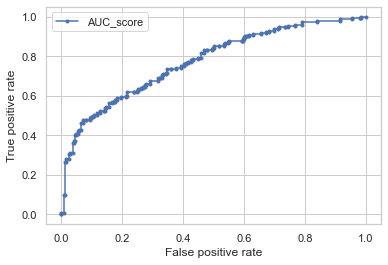

In [40]:
# predict probabilities
# keep probabilities for the positive outcome only
probs = final_model.predict_proba(X_test)[:, 1]

# calculate AUC
auc = roc_auc_score(y_test, probs)
print('LGBM AUC: {:.4f}'.format(auc))

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label='AUC_score')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate') 

# show the plot
plt.legend()
plt.show()

In [33]:
import itertools

# Create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [34]:
from sklearn.metrics import confusion_matrix
y_pred = final_model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[170,  75],
       [ 78, 162]], dtype=int64)

Normalized confusion matrix
[[0.69387755 0.30612245]
 [0.325      0.675     ]]


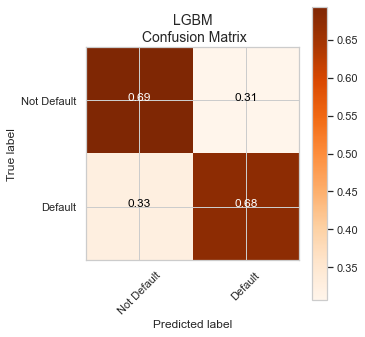

In [41]:
LGBM_conf= confusion_matrix(y_test.values, y_pred)
labels = ['Not Default', 'Default']

fig = plt.figure(figsize=(5,5))
plot_confusion_matrix(LGBM_conf, labels, title="LGBM\n Confusion Matrix", cmap=plt.cm.Oranges, normalize=True)

In [42]:
from sklearn.metrics import classification_report

print('LGBM:')
print(classification_report(y_test.values, y_pred))

LGBM:
              precision    recall  f1-score   support

           0       0.69      0.69      0.69       245
           1       0.68      0.68      0.68       240

    accuracy                           0.68       485
   macro avg       0.68      0.68      0.68       485
weighted avg       0.68      0.68      0.68       485



## 11.5 Important features

In [43]:
col_name =  X_train.columns.values
importances = final_model.feature_importances_
print("Important features length {}".format(len(importances)))

imp_df = pd.DataFrame({'Feature':col_name,  'Importance':importances}) 

imp_df.sort_values(by='Importance', ascending=False,inplace=True)

#get featues with no value
no_value = imp_df[imp_df['Importance'] == 0.0]['Feature'].values.tolist()

print("No value feature count {}".format(len(no_value)))
print(("-" * 25) + "\n")

#return features that add value
imp_df[imp_df['Importance'] > 0.0].reset_index(drop=True)

Important features length 320
No value feature count 58
-------------------------



,Feature,Importance
0,CREDIT_TERM,1238
1,EXT_SOURCE_2,794
2,DAYS_BIRTH,708
3,TIMELY_PERCENT,657
4,EXT_SOURCE_3,655
...,...,...
257,CC_CNT_DRAWINGS_OTHER_CURRENT_STD,1
258,PRE_APP_PRODUCT_COMBINATION_POS_OTHER_WITH_INT...,1
259,BUREAU_CREDIT_DAY_OVERDUE_STD,1
260,BUREAU_CNT_CREDIT_PROLONG_STD,1
